# Food Delivery Time Prediction

### Course: Machine Learning – Tutedude  
### Student: [Mohit Rathore]  
### Tool: Python (pandas, numpy, matplotlib, scikit-learn)

---

## Phase 1: Data Collection and EDA

### Step 1: Data Import and Preprocessing
- Loading dataset
- Handling missing values
- Parsing location coordinates
- Feature engineering (Haversine distance, Rush_Hour)
- Encoding categorical variables
- Scaling features

### Step 2: Exploratory Data Analysis (EDA)
- Descriptive statistics
- Correlation analysis
- Outlier detection (boxplots)

### Step 3: Feature Engineering
- Location-based features
- Time-based features

---

## Phase 2: Predictive Modeling

### Step 4: Linear Regression Model
- Train–test split
- Model training
- Evaluation: MSE, RMSE, MAE, R²
- Actual vs predicted plot

### Step 5: Logistic Regression Model
- Binary label (Fast vs Delayed)
- Train–test split
- Model training
- Evaluation: Accuracy, Precision, Recall, F1-score
- Confusion matrix
- ROC curve and AUC

---

## Phase 3: Reporting and Insights

### Step 6: Model Evaluation and Comparison
- Regression vs Classification

### Step 7: Actionable Insights
- Operational recommendations


In [34]:
# Food Delivery Time Prediction - Tutedude ML Assignment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians, sin, cos, asin, sqrt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)

# Make plots look reasonable
plt.style.use("ggplot")

# Load dataset
df = pd.read_csv("Food_Delivery_Time_Prediction.csv")

# Look at first few rows
df.head()


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [13]:
# Check structure of the dataset
print("Dataset Info:\n")
df.info()

print("\nSummary statistics for numeric columns:\n")
print(df.describe())

print("\nMissing values per column:\n")
print(df.isnull().sum())


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    object 
 5   Traffic_Conditions          200 non-null    object 
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    object 
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    float64
 13  Order_Cost          

In [14]:
# Simple missing value handling: drop rows with any missing values
df = df.dropna().reset_index(drop=True)
print("Shape after dropping missing values:", df.shape)


Shape after dropping missing values: (200, 15)


In [15]:
# Parse "(lat, lon)" text into numeric latitude and longitude

def parse_location(s):
    s = s.strip("()")
    lat_str, lon_str = s.split(",")
    return float(lat_str), float(lon_str)

# Customer coordinates
df[["Cust_Lat", "Cust_Lon"]] = df["Customer_Location"].apply(
    lambda x: pd.Series(parse_location(x))
)

# Restaurant coordinates
df[["Rest_Lat", "Rest_Lon"]] = df["Restaurant_Location"].apply(
    lambda x: pd.Series(parse_location(x))
)

df[["Customer_Location", "Restaurant_Location", "Cust_Lat", "Cust_Lon", "Rest_Lat", "Rest_Lon"]].head()


,Customer_Location,Restaurant_Location,Cust_Lat,Cust_Lon,Rest_Lat,Rest_Lon
0,"(17.030479, 79.743077)","(12.358515, 85.100083)",17.030479,79.743077,12.358515,85.100083
1,"(15.398319, 86.639122)","(14.174874, 77.025606)",15.398319,86.639122,14.174874,77.025606
2,"(15.687342, 83.888808)","(19.594748, 82.048482)",15.687342,83.888808,19.594748,82.048482
3,"(20.415599, 78.046984)","(16.915906, 78.278698)",20.415599,78.046984,16.915906,78.278698
4,"(14.786904, 78.706532)","(15.206038, 86.203182)",14.786904,78.706532,15.206038,86.203182


In [16]:
# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of Earth in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

# Add Haversine distance as a new feature
df["Haversine_Distance"] = df.apply(
    lambda row: haversine(row["Cust_Lat"], row["Cust_Lon"],
                          row["Rest_Lat"], row["Rest_Lon"]),
    axis=1
)

df[["Distance", "Haversine_Distance"]].head()


,Distance,Haversine_Distance
0,1.57,775.651198
1,21.32,1042.385597
2,6.95,476.220706
3,13.79,389.912629
4,6.72,806.505886


In [17]:
# Create Rush_Hour feature: Afternoon and Evening = 1, else 0

def is_rush_hour(order_time):
    if order_time in ["Afternoon", "Evening"]:
        return 1
    else:
        return 0

df["Rush_Hour"] = df["Order_Time"].apply(is_rush_hour)

df[["Order_Time", "Rush_Hour"]].head()


,Order_Time,Rush_Hour
0,Afternoon,1
1,Night,0
2,Night,0
3,Evening,1
4,Night,0


In [18]:
# Categorical columns to one‑hot encode
categorical_cols = [
    "Weather_Conditions",
    "Traffic_Conditions",
    "Order_Priority",
    "Order_Time",
    "Vehicle_Type"
]

# One‑hot encoding using pandas
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df_encoded.head()


,Order_ID,Customer_Location,Restaurant_Location,Distance,Delivery_Person_Experience,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Cust_Lat,Cust_Lon,Rest_Lat,Rest_Lon,Haversine_Distance,Rush_Hour,Weather_Conditions_Rainy,Weather_Conditions_Snowy,Weather_Conditions_Sunny,Traffic_Conditions_Low,Traffic_Conditions_Medium,Order_Priority_Low,Order_Priority_Medium,Order_Time_Evening,Order_Time_Morning,Order_Time_Night,Vehicle_Type_Bike,Vehicle_Type_Car
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,4,4.1,3.0,26.22,1321.10,81.54,17.030479,79.743077,12.358515,85.100083,775.651198,1,True,False,False,False,True,False,True,False,False,False,False,True
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,8,4.5,4.2,62.61,152.21,29.02,15.398319,86.639122,14.174874,77.025606,1042.385597,0,False,False,False,False,True,True,False,False,False,True,False,True
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,9,3.3,3.4,48.43,1644.38,64.17,15.687342,83.888808,19.594748,82.048482,476.220706,0,False,True,False,False,True,False,False,False,False,True,True,False
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,2,3.2,3.7,111.63,541.25,79.23,20.415599,78.046984,16.915906,78.278698,389.912629,1,False,False,False,True,False,False,True,True,False,False,True,False
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,6,3.5,2.8,32.38,619.81,2.34,14.786904,78.706532,15.206038,86.203182,806.505886,0,True,False,False,False,False,True,False,False,False,True,True,False


In [19]:
df_encoded.describe()


,Distance,Delivery_Person_Experience,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Cust_Lat,Cust_Lon,Rest_Lat,Rest_Lon,Haversine_Distance,Rush_Hour
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,11.498050,5.250000,3.738500,3.686500,70.494950,1046.488700,46.616650,16.997762,82.478466,16.675150,82.579902,603.037915,0.580000
std,6.841755,2.745027,0.703021,0.697063,29.830694,548.568922,29.361706,3.097039,3.151669,2.837942,3.286385,269.796797,0.494797
min,0.520000,1.000000,2.500000,2.600000,15.230000,122.300000,1.240000,12.021992,77.018445,12.019922,77.010580,29.871927,0.000000
25%,6.090000,3.000000,3.200000,3.100000,46.997500,553.270000,21.602500,14.368618,79.700913,14.171155,79.617649,389.197293,0.000000
50%,10.265000,5.000000,3.800000,3.700000,72.775000,1035.950000,47.530000,17.081582,82.271895,16.516376,82.482346,558.788921,1.000000
75%,16.497500,8.000000,4.300000,4.300000,96.650000,1543.125000,70.245000,20.091919,85.400211,18.829646,85.628492,807.602442,1.000000
max,24.900000,10.000000,5.000000,5.000000,119.670000,1997.420000,99.740000,21.941596,87.968582,21.990214,87.896124,1299.244267,1.000000


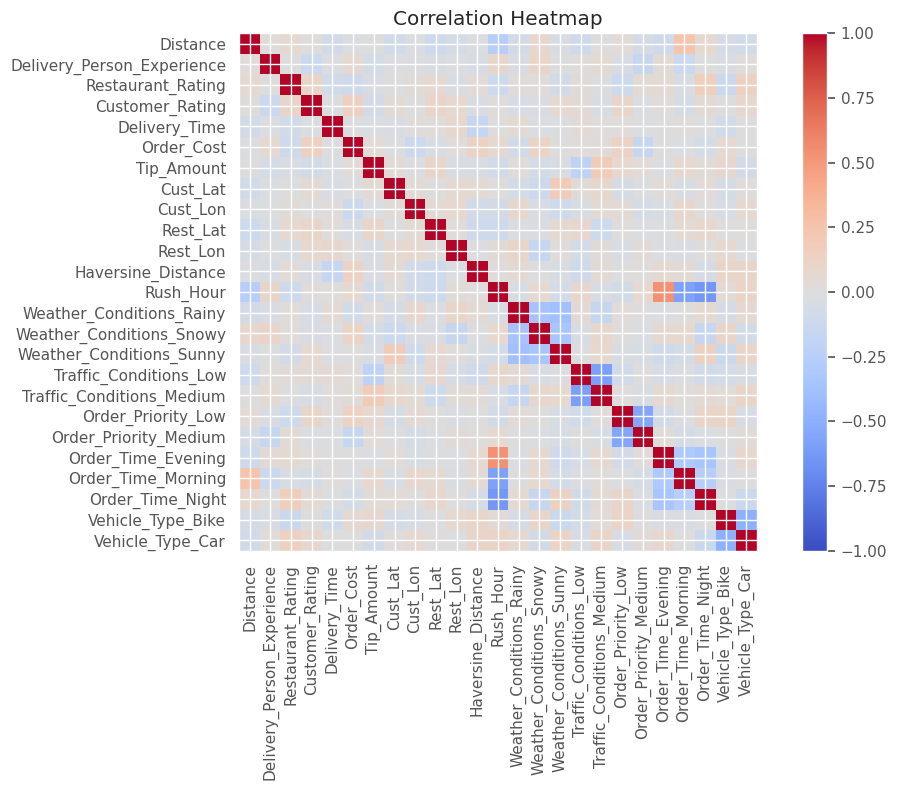

,Delivery_Time
Delivery_Time,1.000000
Rest_Lon,0.083964
Weather_Conditions_Rainy,0.054402
Traffic_Conditions_Low,0.039714
Rest_Lat,0.018548
Order_Priority_Low,0.012849
Order_Time_Morning,0.011984
Traffic_Conditions_Medium,0.011810
Cust_Lon,0.008253
Rush_Hour,0.002201


In [20]:
# Correlation matrix of numeric features
corr = df_encoded.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Correlation of each feature with Delivery_Time
corr_with_delivery = corr["Delivery_Time"].sort_values(ascending=False)
corr_with_delivery


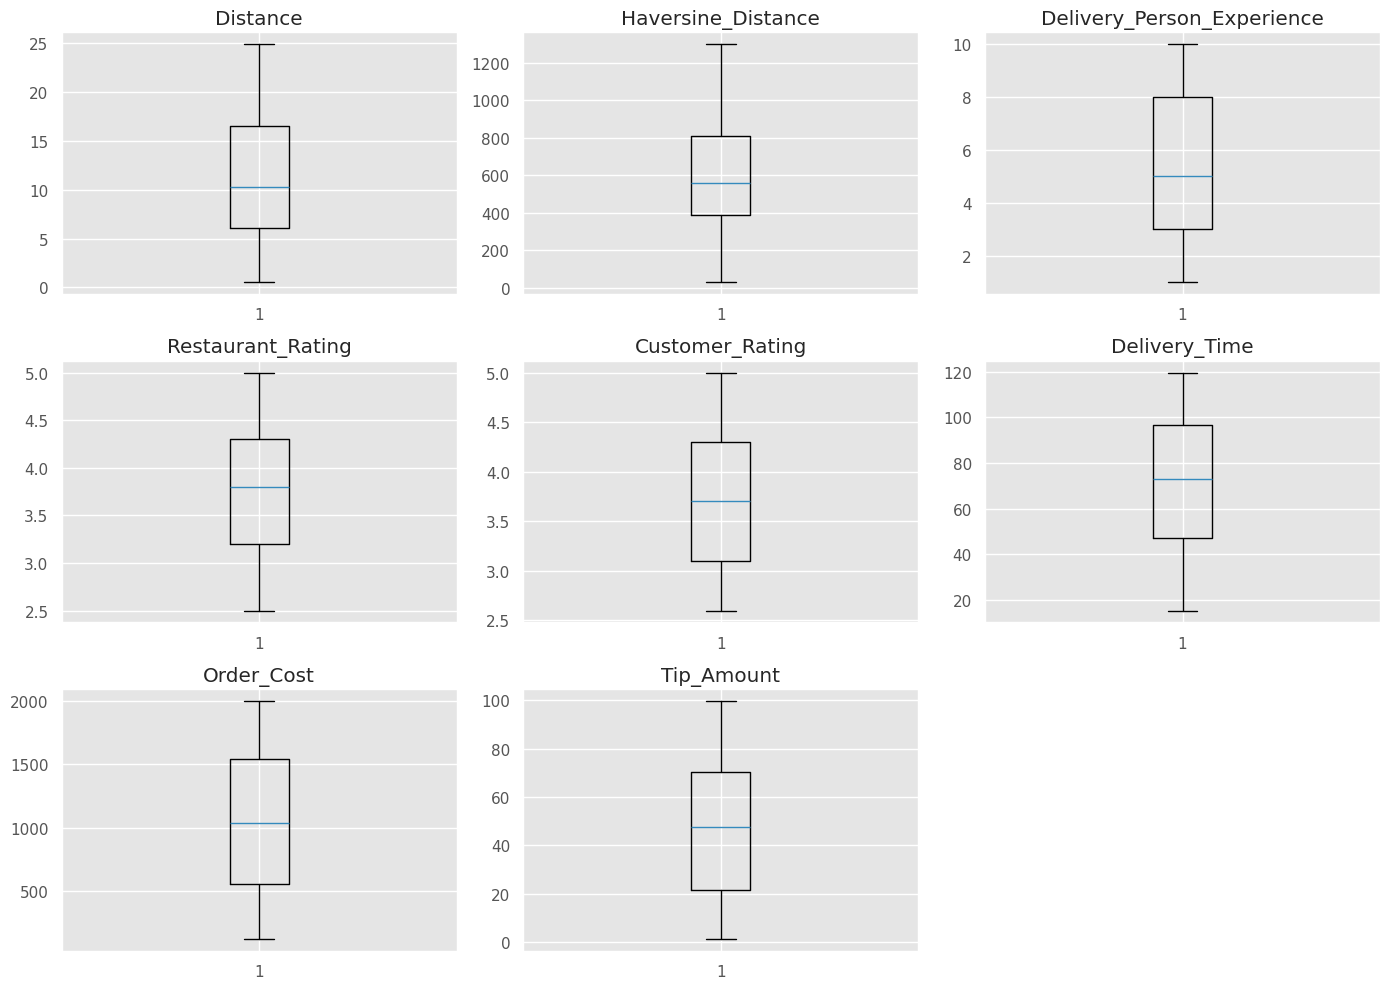

In [21]:
numeric_cols = [
    "Distance", "Haversine_Distance", "Delivery_Person_Experience",
    "Restaurant_Rating", "Customer_Rating", "Delivery_Time",
    "Order_Cost", "Tip_Amount"
]

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(df_encoded[col].values, vert=True)
    plt.title(col)
plt.tight_layout()
plt.show()


In [22]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

for col in ["Delivery_Time", "Distance", "Haversine_Distance"]:
    df_encoded = remove_outliers_iqr(df_encoded, col)

df_encoded.shape


(200, 28)

In [23]:
# Features and target for regression
X_reg = df_encoded.drop(columns=[
    "Order_ID",
    "Customer_Location",
    "Restaurant_Location",
    "Delivery_Time"
])
y_reg = df_encoded["Delivery_Time"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Standardize features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)


In [24]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg_scaled, y_train_reg)

y_pred_reg = lin_reg.predict(X_test_reg_scaled)


In [25]:
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)

print("Linear Regression Performance:")
print(f"  MSE  : {mse:.2f}")
print(f"  RMSE : {rmse:.2f}")
print(f"  R^2  : {r2:.3f}")
print(f"  MAE  : {mae:.2f}")


Linear Regression Performance:
  MSE  : 957.16
  RMSE : 30.94
  R^2  : -0.035
  MAE  : 26.52


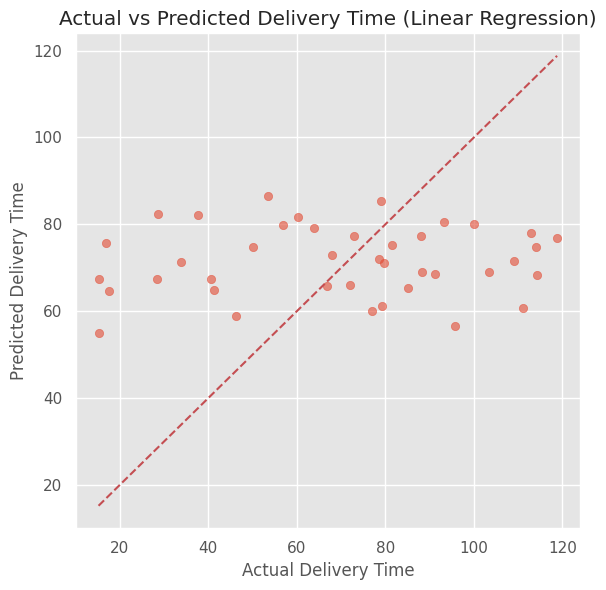

In [26]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6)
plt.xlabel("Actual Delivery Time")
plt.ylabel("Predicted Delivery Time")
plt.title("Actual vs Predicted Delivery Time (Linear Regression)")

min_val = min(y_test_reg.min(), y_pred_reg.min())
max_val = max(y_test_reg.max(), y_pred_reg.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.tight_layout()
plt.show()


In [27]:
# Use median delivery time to define Fast vs Delayed
median_time = df_encoded["Delivery_Time"].median()
df_encoded["Delivery_Status"] = (df_encoded["Delivery_Time"] > median_time).astype(int)
# 0 = Fast, 1 = Delayed

df_encoded[["Delivery_Time", "Delivery_Status"]].head()


,Delivery_Time,Delivery_Status
0,26.22,0
1,62.61,0
2,48.43,0
3,111.63,1
4,32.38,0


In [28]:
X_cls = df_encoded.drop(columns=[
    "Order_ID",
    "Customer_Location",
    "Restaurant_Location",
    "Delivery_Time",
    "Delivery_Status"
])
y_cls = df_encoded["Delivery_Status"]

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)


In [29]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_cls_scaled, y_train_cls)

y_pred_cls = log_reg.predict(X_test_cls_scaled)
y_pred_cls_proba = log_reg.predict_proba(X_test_cls_scaled)[:, 1]


In [30]:
acc = accuracy_score(y_test_cls, y_pred_cls)
prec = precision_score(y_test_cls, y_pred_cls)
rec = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)
cm = confusion_matrix(y_test_cls, y_pred_cls)

print("Logistic Regression Performance:")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-score : {f1:.3f}")
print("\nConfusion Matrix:\n", cm)


Logistic Regression Performance:
  Accuracy : 0.500
  Precision: 0.500
  Recall   : 0.450
  F1-score : 0.474

Confusion Matrix:
 [[11  9]
 [11  9]]


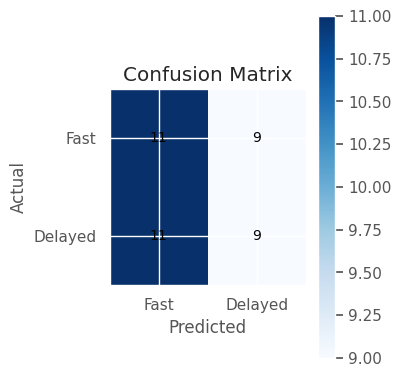

In [31]:
# Plot confusion matrix with matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
classes = ["Fast", "Delayed"]
tick_marks = [0, 1]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


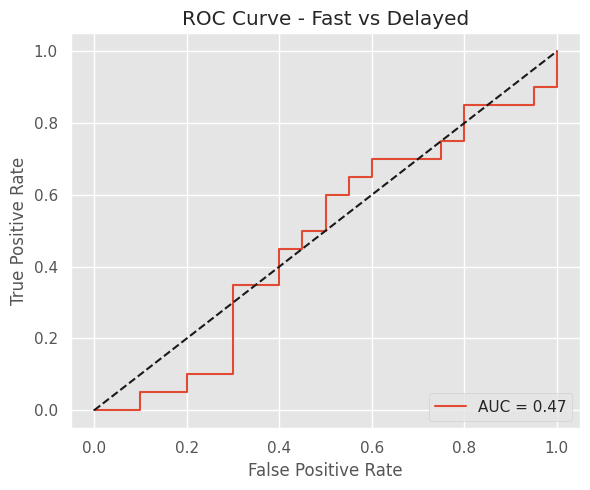

In [32]:
fpr, tpr, thresholds = roc_curve(y_test_cls, y_pred_cls_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fast vs Delayed")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [33]:
print("===== Linear Regression (Delivery_Time) =====")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R^2  : {r2:.3f}")
print(f"MAE  : {mae:.2f}")

print("\n===== Logistic Regression (Fast vs Delayed) =====")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"AUC      : {roc_auc:.3f}")



===== Linear Regression (Delivery_Time) =====
MSE  : 957.16
RMSE : 30.94
R^2  : -0.035
MAE  : 26.52

===== Logistic Regression (Fast vs Delayed) =====
Accuracy : 0.500
Precision: 0.500
Recall   : 0.450
F1-score : 0.474
AUC      : 0.475


In [35]:
print("mse =", mse)
print("rmse =", rmse)
print("mae =", mae)
print("r2 =", r2)

print("acc =", acc)
print("prec =", prec)
print("rec =", rec)
print("f1 =", f1)
print("roc_auc =", roc_auc)


mse = 957.1594101572653
rmse = 30.937992988512768
mae = 26.523110128427327
r2 = -0.03488864462166319
acc = 0.5
prec = 0.5
rec = 0.45
f1 = 0.47368421052631576
roc_auc = 0.475
